# Introduction

Lets load our environment first

In [1]:
from func_adl_servicex import ServiceXSourceUpROOT, ServiceXSourceCMSRun1AOD
from hist import Hist
import awkward as ak

## Flat ROOT Files

ATLAS has distributed it's open data as flat ROOT files.

* On CERNOpenData they are a single zip file
* But they have been distributed as files availible via EOS from CERN Open Data's EOS instance.

In [2]:
ggH125_ZZ4lep = 'root://eospublic.cern.ch//eos/opendata/atlas/OurestartreachDatasets/2020-01-22/4lep/MC/mc_345060.ggH125_ZZ4lep.4lep.root'
ggH125_ZZ4lep = 'https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/MC/mc_345060.ggH125_ZZ4lep.4lep.root'
ggH125_ZZ4lep_source = ServiceXSourceUpROOT([ggH125_ZZ4lep], 'mini', backend='open_uproot')

* We use the `root://` address instead of `http://` due to efficiency and caching.
* `mini` is the tree name in the file
* `backend` basically describes the type of file - this is a flat root file that can be opened by the `uproot` python package.

Now that we have a reference to the datasource, lets pick out a single column and bring its contents back to our local instance:

In [3]:
from servicex import ignore_cache

with ignore_cache():
    r = (ggH125_ZZ4lep_source
         .Select(lambda e: {'lep_pt': e['lep_pt']})
         .AsAwkwardArray()
         .value()
        )
r

https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/MC/mc_345060.ggH125_ZZ4lep.4lep.root:   0%…

        Downloaded:   0%|                                                                                     …

<Array [{lep_pt: [5.19e+04, ... 1.11e+04]}] type='164716 * {"lep_pt": var * floa...'>

This is a standard awkward array - and it's shape is simply a series of lepton $p_T$'s for each of the 164716 events:

In [4]:
r.type

164716 * {"lep_pt": var * float32}

Lets plot this. We'll use the `Hist` library, which is a nice wrapper around the `boost_histogram` library:
* Note we have a single axis, which is the muon's $p_T$

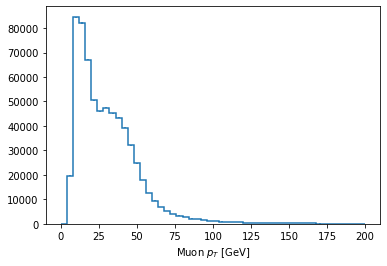

In [5]:
h = (Hist.new
     .Reg(50, 0, 200, name='mu_pt', label='Muon $p_T$ [GeV]')
     .Int64()
     )
h.fill(ak.flatten(r['lep_pt'])/1000.0)
_ = h.plot()

Lets get back a $p_T$ and an $\eta$ for the leptons now. This requires two things coming back:

In [6]:
r = (ggH125_ZZ4lep_source
     .Select(lambda e: {'lep_pt': e['lep_pt'], 'lep_eta': e['lep_eta']})
     .AsAwkwardArray()
     .value()
    )
r.type

164716 * {"lep_pt": var * float32, "lep_eta": var * float32}

Note that it is columnar data:

* Each event contains two arrays
* The arrays are lepton pt and eta - not a tuple of lepton ($p_T$, $\eta$).

What if we want to cut on the eta? How do we relate these two columns? We use the zip function.

In [7]:
r_cut = (ggH125_ZZ4lep_source
         .Select(lambda e: Zip({'pt': e['lep_pt'], 'eta': e['lep_eta']}))
         .Select(lambda leps: leps.Where(lambda l: abs(l.eta) < 1.0))
         .AsAwkwardArray()
         .value()
        )
r.type

164716 * {"lep_pt": var * float32, "lep_eta": var * float32}

Interesting - same number of events - but we cut? Lets look at a histogram:

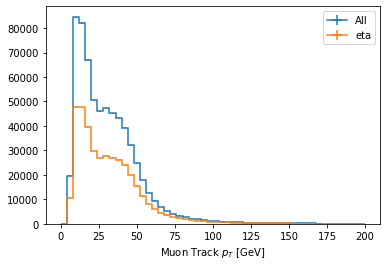

In [8]:
h = (Hist.new
     .Reg(50, 0, 200, name='mu_pt', label='Muon Track $p_T$ [GeV]')
     .StrCat([], name='cut', label='Cut Type', growth=True)
     .Int64()
     )
h.fill(mu_pt=ak.flatten(r['lep_pt'])/1000.0, cut='All')
h.fill(mu_pt=ak.flatten(r_cut['pt'])/1000.0, cut='eta')
artists = h.plot()

ax = artists[0].stairs.axes  # get the axis
ax.legend(loc="best");

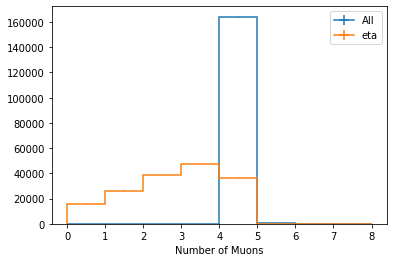

In [9]:
h = (Hist.new
     .Reg(8, 0, 8, name='muon_count', label='Number of Muons')
     .StrCat([], name='cut', label='Cut Type', growth=True)
     .Int64()
     )
h.fill(muon_count=ak.count(r['lep_pt'], axis=-1), cut='All')
h.fill(muon_count=ak.count(r_cut['pt'], axis=-1), cut='eta')
artists = h.plot()

ax = artists[0].stairs.axes  # get the axis
ax.legend(loc="best");

* We cut the number of leptons per event
* We now have some events with zero leptons - but those events were still returned
* We could remove them by doing a cut on the number of leptons...

## CMS Run 1 AOD Files

Differences between FLAT ROOT files and CMS RUN 1 AOD Files:

* You must use an (old) version of CMSSW, a big software framework, to read these files!!
* Data in these files is stored event or row-wise: electrons, and then the $p_T$ and $\eta$ of each electron.
* Some datasets are ~7 TB!! It takes about 30 minutes to run on those when things are working well: we will be using a data from an earlier run that has automatically been locally cached.

Start with a 60GB SM [Higgs dataset](http://opendata.cern.ch/record/1507) ($H \rightarrow ZZ \rightarrow \ell \ell \ell \ell$). In CERN OpenData's catalog, this is record 1507 (pulled straight from the URL: http://opendata.cern.ch/record/1507).

In [10]:
hzz_4l_source = ServiceXSourceCMSRun1AOD('cernopendata://1507', backend='cms_run1_aod')

In [11]:
r = (hzz_4l_source \
     .Select(lambda e: e.TrackMuons("globalMuons"))
     .Select(lambda muons: muons.Select(lambda m: m.pt()))
     .AsAwkwardArray(['mu_pt']) \
     .value()
    )
r.type

299683 * {"mu_pt": var * float64}

In [12]:
r_cut = (hzz_4l_source \
         .Select(lambda e: e.TrackMuons("globalMuons"))
         .Select(lambda muons: muons.Where(lambda m: abs(m.eta()) < 1.0))
         .Select(lambda muons: muons.Select(lambda m: m.pt()))
         .AsAwkwardArray(['mu_pt']) \
         .value()
    )
r.type

299683 * {"mu_pt": var * float64}

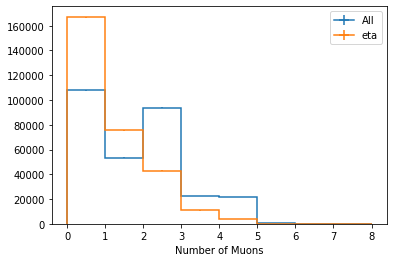

In [13]:
h = (Hist.new
     .Reg(8, 0, 8, name='muon_count', label='Number of Muons')
     .StrCat([], name='cut', label='Cut Type', growth=True)
     .Int64()
     )
h.fill(muon_count=ak.count(r['mu_pt'], axis=-1), cut='All')
h.fill(muon_count=ak.count(r_cut['mu_pt'], axis=-1), cut='eta')
artists = h.plot()

ax = artists[0].stairs.axes  # get the axis
ax.legend(loc="best");

Again, a very similar behavior here!

* Note that CMS muons are **all** muons, so a lot more quality cuts must be done to compare them with ATLAS's muons.
* ATLAS's AOD files were skimmed down to make those datasets for the educational purposes: so a lot of the skimming is done early for those files.

## Using Coffea

`ServiceX`:

* Gets columnar data from any format that can a translator has been written for (ATLAS Run 2 xAOD, CMS Run 1 AOD, uproot-able ROOT files, soon some dark matter experiments, etc.)
* Slims, skims, generates calculated quantities

Think _ntuplizer_.

`coffea`:

* Used `awkward` and friends to perform the final analysis
* Plotting
* Distributed running
* Good at running on a large number of datasets at once

`coffea` is arranged around processors that do the physics. Each processor runs once per file, and results are combined for a dataset.

First define a dummy (representative) dataset and apply the operations on it we are interested in:

In [14]:
ds = ServiceXSourceUpROOT('cernopendata://dummy',  "mimi", backend='open_uproot')
ds.return_qastle = True  # Magic

selection_atlas = (ds
                     .Select(lambda e: Zip({'lep_pt': e['lep_pt'], 'lep_eta': e['lep_eta']}))
                     .Select(lambda leps: leps.Where(lambda l: abs(l.lep_eta) < 1.0))
                     .Select(lambda leps: {'lep_pt': leps.lep_pt, 'lep_eta': leps.lep_eta})
                     .AsParquetFiles('junk.parquet')
                  )

Note:

* no call to `value`: We do not want to try to render this bogus expression.
* We want to return parquet files - this is what `coffea` will be eating and sending to the processors.

In [15]:
from coffea.processor.servicex import DataSource, Analysis
from coffea.processor.servicex import LocalExecutor
from servicex import ServiceXDataset
from coffea import processor

class atlas_demo_processor(Analysis):
    @staticmethod
    def process(events):
        import awkward as ak
        from collections import defaultdict

        sumw = defaultdict(float)
        h = (Hist.new
             .Reg(50, 0, 200, name='lep_pt', label='Lepton $p_T$ [GeV]')
             .StrCat([], name='dataset', label='Dataset', growth=True)
             .Int64()
             )

        dataset = events.metadata['dataset']
        leptons = events.lep

        h.fill(
            dataset=dataset,
            lep_pt = ak.flatten(leptons.pt/1000.0)
        )
                
        return {
            "sumw": sumw,
            "pt": h
        }

Now we create a real dataset and execute it.

In [16]:
datasets = [ServiceXDataset([ggH125_ZZ4lep], backend_type='open_uproot',
                           image='sslhep/servicex_func_adl_uproot_transformer:pr_fix_awk_bug')]
c_datasets = DataSource(query=selection_atlas, metadata={'dataset': 'ggH125_ZZ4lep'}, datasets=datasets)

This code is boiler plate:

* Declare a dataset and a transformer image (were accidentally running an old version of awkward)
* Create a datasource
* Note the metadata - a useful way to pass information into your processor on a per-dataset basis.

In [17]:
analysis = atlas_demo_processor()
executor = LocalExecutor(datatype='parquet')

async def run_updates_stream(accumulator_stream):
  count = 0
  async for coffea_info in accumulator_stream:
    count += 1
  return coffea_info

result = await run_updates_stream(executor.execute(analysis, c_datasets))
print(result)

{'sumw': defaultdict(<class 'float'>, {}), 'pt': Hist(
  Regular(50, 0, 200, name='lep_pt', label='Lepton $p_T$ [GeV]'),
  StrCategory(['ggH125_ZZ4lep'], growth=True, name='dataset', label='Dataset'),
  storage=Int64()) # Sum: 392955.0 (393351.0 with flow)}


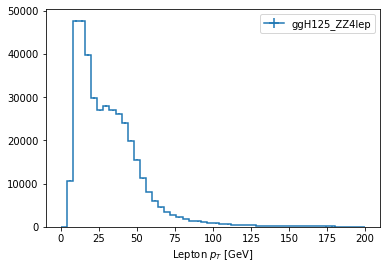

In [18]:
artists = result['pt'].plot()

ax = artists[0].stairs.axes  # get the axis
ax.legend(loc="best");